In [42]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style = "float:right" type="submit" value="Toggle code">''')


In [43]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, log_loss
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [44]:
# Setting up visualisations
sns.set_style(style='white') 
sns.set(rc={
    'figure.figsize':(12,7), 
    'axes.facecolor': 'white',
    'axes.grid': True, 'grid.color': '.9',
    'axes.linewidth': 1.0,
    'grid.linestyle': u'-'},font_scale=1.5)
custom_colors = ["#3498db", "#95a5a6","#34495e", "#2ecc71", "#e74c3c"]
sns.set_palette(custom_colors)

In [45]:
#Reading the data from the CSV file. We use a flag IS_FOR_KAGGLE to toggle the path of the data file.
IS_FOR_KAGGLE = False

if IS_FOR_KAGGLE:
    trd = pd.read_csv('../input/train.csv')
    tsd = pd.read_csv('../input/test.csv')
else:
    trd = pd.read_csv('train.csv')
    tsd = pd.read_csv('test.csv')

td = pd.concat([trd, tsd], ignore_index=True, sort  = False)

### 1. Getting the hang of the data

The data contains 1309 rows and 12 colunmns. Each row signifies a human on the deck and each column is an attribute corresponding to that human.

In [46]:
td.shape

(1309, 12)

On diving deeper in to the columns, we see five integer type columns, five object types (strings) and two columns with decimal values. Also, all the columns do not have 1309 values which indicates that there are missing values.

In [47]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### 2. Missing values

The line plot and the heat map below show the number of missing values in all columns. There are multiple columns that have missing values

- Age 
- Cabin
- Embarked
- Fare
- Survived

**77.5%** of data is NOT available for the column 'Cabin'. Hence, it can be dropped in our analysis and prediction. An alternate approach would have been to predict values for the missing values. However, it is not recommended as the number of values available for Cabin is significantly lower.

In contrast, Embarked has only 2 missing missing values. As the column contains **0.15%** missing values, the values can be substituted by the mode of the column. 

The column 'Age' on the other hand has 177 missing values which contribute to **20%** on the total expected values. We will impute the age data by categorising people on the basis of their title and finding the median age.

Fare has one missing value.

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

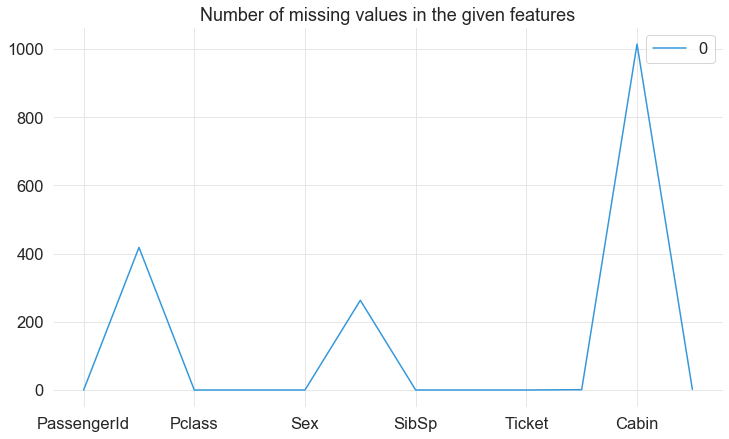

In [48]:
pd.DataFrame(td.isnull().sum()).plot.line().set_title("Number of missing values in the given features")
td.isnull().sum()

Text(0.5, 1, 'Missing values heatmap')

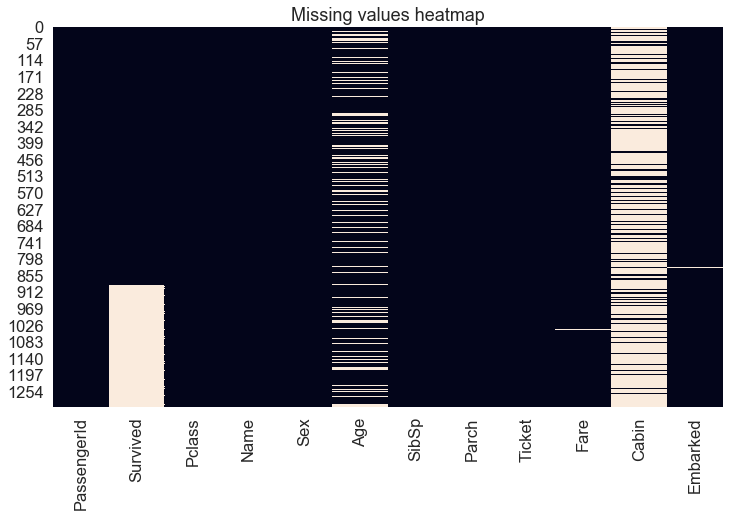

In [49]:
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")


### 3. Number of unique values

To comprehend the categorical data in the training data, we list down al the columns with the number of unique values they have. We infer that 

- survived and Sex can have **two** distinct values
- Embarked and PClass have **three** distinct values

So, we have four columns of cateogrical data - **Survived, Sex, Embarked and PClass**.

In [50]:
td.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
dtype: int64

# Features

### 4. Survived ###

The horizontal bar plot below shows the percentage of people that survived and percentage of people that unfortunately couldn't make it out alive from the disaster. **More than 60% of the people on the ship died.**

Text(0.5, 1.0, 'Training Data - Percentage of people survived and Deceased')

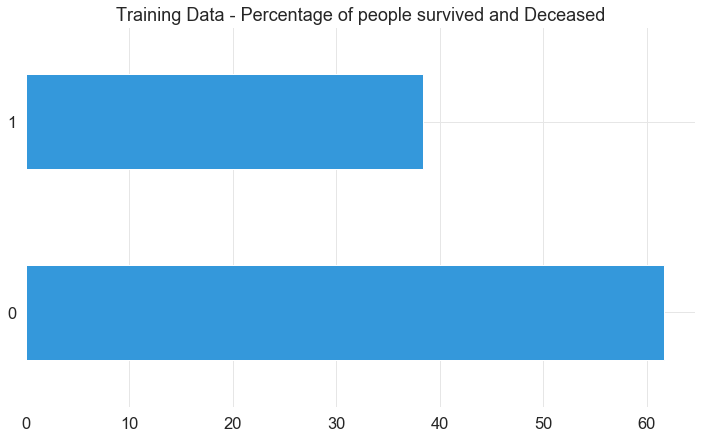

In [51]:
(trd.Survived.value_counts(normalize=True) * 100).plot.barh().set_title("Training Data - Percentage of people survived and Deceased")


### 5. Pclass ###

Pclass or passenger class represents the traveling class of commuter. There were three classes. In the combined dataset, a clear majority **(709)** traveled in the third class, followed by the second **(277)** and then the first **(323)**. 

**The number of passengers in the third class was more than the number of passengers in first and second class combined.**

**With the missing survived values, More than 40% of the first class passengers were rescued.** The pattern differed for the second and third class survivors as roughly around **70% of the second class passengers lost their lives**. The numbers skyrocketed for the third class passengers. More than **80% of the third class passengers couldn't survive** the disaster.




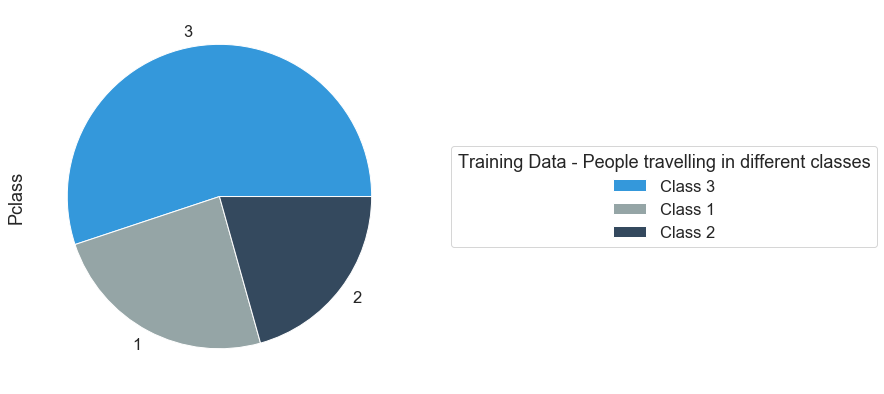

In [52]:
fig_pclass = trd.Pclass.value_counts().plot.pie().legend(labels=["Class 3","Class 1","Class 2"], loc='center right', bbox_to_anchor=(2.25, 0.5)).set_title("Training Data - People travelling in different classes")


Text(0.5, 1.0, 'Training Data - Percentage of people survived on the basis of class')

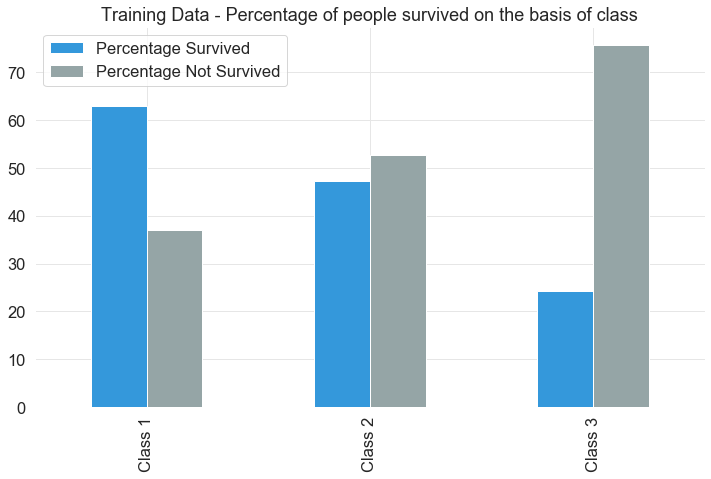

In [53]:
pclass_1_survivor_distribution = round((trd[trd.Pclass == 1].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 1]) * 100, 2)
pclass_2_survivor_distribution = round((trd[trd.Pclass == 2].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 2]) * 100, 2)
pclass_3_survivor_distribution = round((trd[trd.Pclass == 3].Survived == 1).value_counts()[1]/len(trd[trd.Pclass == 3]) * 100, 2)
pclass_perc_df = pd.DataFrame(
    { "Percentage Survived":{"Class 1": pclass_1_survivor_distribution,"Class 2": pclass_2_survivor_distribution, "Class 3": pclass_3_survivor_distribution},  
     "Percentage Not Survived":{"Class 1": 100-pclass_1_survivor_distribution,"Class 2": 100-pclass_2_survivor_distribution, "Class 3": 100-pclass_3_survivor_distribution}})
pclass_perc_df.plot.bar().set_title("Training Data - Percentage of people survived on the basis of class")


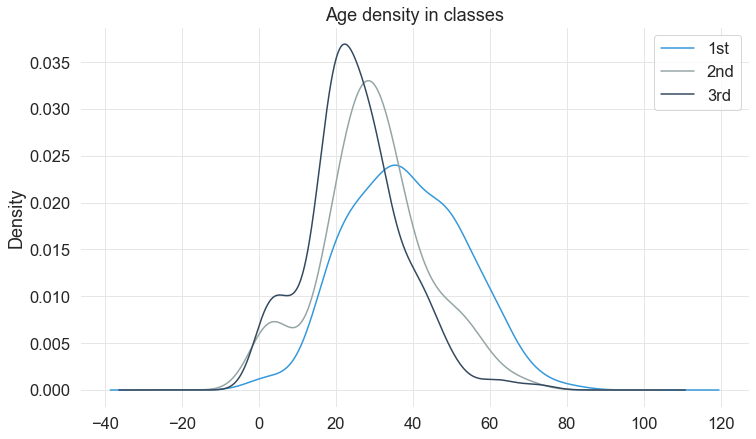

In [54]:
for x in [1,2,3]:    ## for 3 classes
    trd.Age[trd.Pclass == x].plot(kind="kde")
plt.title("Age density in classes")
plt.legend(("1st","2nd","3rd"))

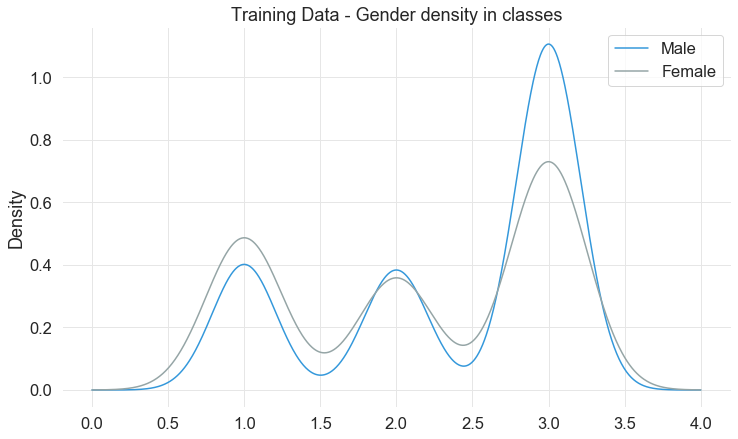

In [55]:
for x in ["male","female"]:
    td.Pclass[td.Sex == x].plot(kind="kde")
plt.title("Training Data - Gender density in classes")
plt.legend(("Male","Female"))

In [56]:
pclass_perc_df

,Percentage Survived,Percentage Not Survived
Class 1,62.96,37.04
Class 2,47.28,52.72
Class 3,24.24,75.76


### 6. Sex

Roughly around **65% of the tourists were male** while the remaining 35% were female. However, the percentage of female survivors was higher than the number of male survivors.

More than 80% male passengers had to die as compared to around 70% female passengers.

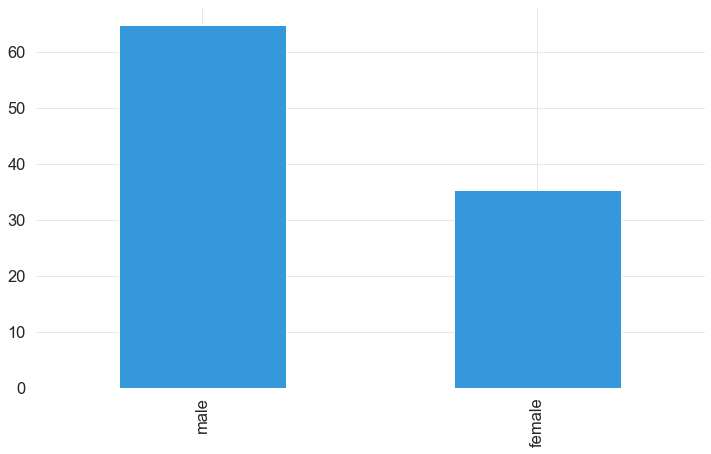

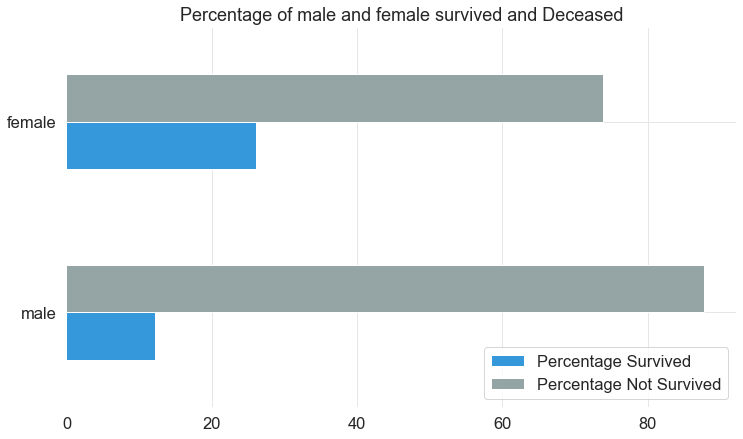

In [57]:
fig_sex = (trd.Sex.value_counts(normalize = True) * 100).plot.bar()
male_pr = round((trd[trd.Sex == 'male'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
female_pr = round((trd[trd.Sex == 'female'].Survived == 1).value_counts()[1]/len(trd.Sex) * 100, 2)
sex_perc_df = pd.DataFrame(
    { "Percentage Survived":{"male": male_pr,"female": female_pr},  "Percentage Not Survived":{"male": 100-male_pr,"female": 100-female_pr}})
sex_perc_df.plot.barh().set_title("Percentage of male and female survived and Deceased")
fig_sex

### 7. Age

The description of column 'Age' tells us that the **youngest traveler onboard was aged around 2 months** and the **oldest commuter was 80 years**. The **average age of passengers onboard was just under 30 years.** 
However, it must be remembered that these observations are with missing values. Since we know that the oldest passenger was 80, we can plot age range and number of people survived or died for that age range.

Apparently, higher number of children below age 10 were saved than died. For every other age group, the number of casualities was higher than the number of survivors. More than 140 people within the age group 20 and 30 were dead as compared to just around 80 people of the same age range sustained.

In [58]:
pd.DataFrame(td.Age.describe())

,Age
count,1046.000000
mean,29.881138
std,14.413493
min,0.170000
25%,21.000000
50%,28.000000
75%,39.000000
max,80.000000


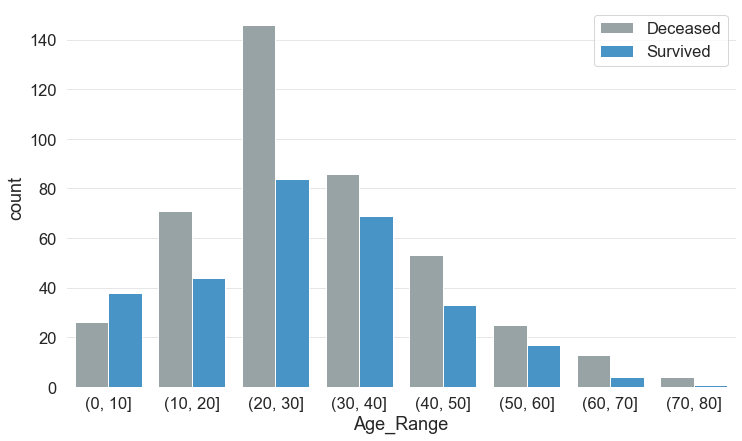

In [59]:
td['Age_Range'] = pd.cut(td.Age, [0, 10, 20, 30, 40, 50, 60,70,80])
sns.countplot(x = "Age_Range", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])


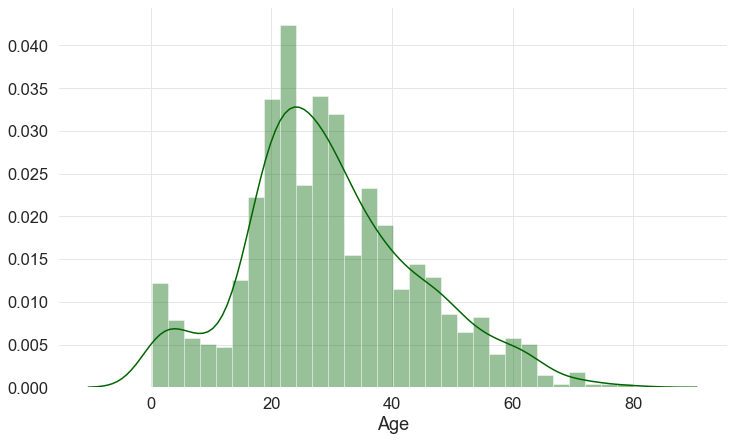

In [60]:
sns.distplot(td['Age'].dropna(),color='darkgreen',bins=30)

### 8. SibSp

SibSp is the number of siblings or spouse of a person onboard. A maximum of 8 siblings and spouses traveled along with one of the tourists.

**More than 90% people traveled alone or with one of their sibling or spouse**.

The chances of survival dropped drastically if someone traveled with more than 2 siblings or spouse.

In [61]:
td.SibSp.describe()

count    1309.000000
mean        0.498854
std         1.041658
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         8.000000
Name: SibSp, dtype: float64

Text(0.5, 1.0, 'Training Data - Number of siblings or spouses vs survival count')

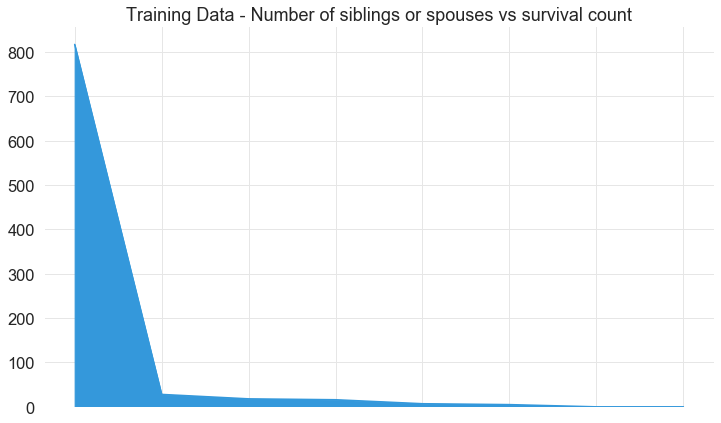

In [62]:
ss = pd.DataFrame()
ss['survived'] = trd.Survived
ss['sibling_spouse'] = pd.cut(trd.SibSp, [0, 1, 2, 3, 4, 5, 6,7,8], include_lowest = True)
(ss.sibling_spouse.value_counts()).plot.area().set_title("Training Data - Number of siblings or spouses vs survival count")

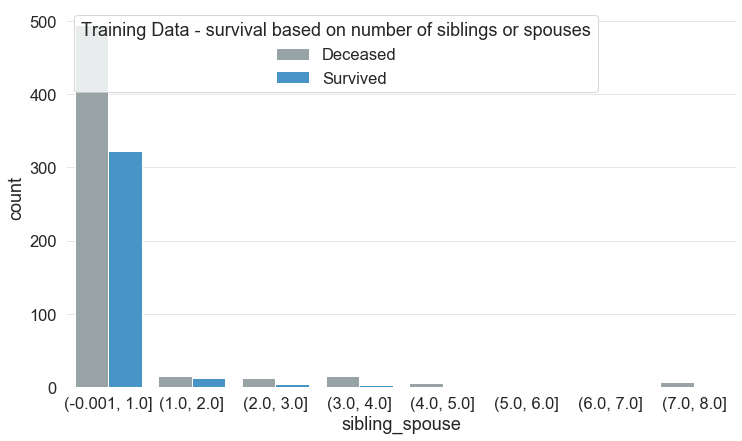

In [63]:
x = sns.countplot(x = "sibling_spouse", hue = "survived", data = ss, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Training Data - survival based on number of siblings or spouses")

### 9. Parch

Similar to the SibSp, this feature contained the number of parents or children each passenger was traveling with. A maximum of 9 parents/children traveled along with one of the passenger.

We will create two new columns, a column named family will have the sum of the number of siblings/spouse and number of parents/children. 

People traveling alone had higher chances of survival. So, we also create a column Is_Alone



In [64]:
pd.DataFrame(td.Parch.describe())

,Parch
count,1309.000000
mean,0.385027
std,0.865560
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,9.000000


Text(0.5, 1.0, 'Training Data - Number of parents/children and survival density')

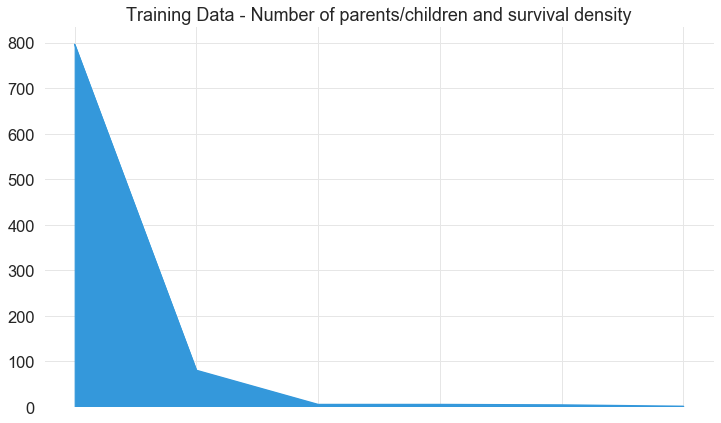

In [65]:
pc = pd.DataFrame()
pc['survived'] = trd.Survived
pc['parents_children'] = pd.cut(trd.Parch, [0, 1, 2, 3, 4, 5, 6], include_lowest = True)
(pc.parents_children.value_counts()).plot.area().set_title("Training Data - Number of parents/children and survival density")

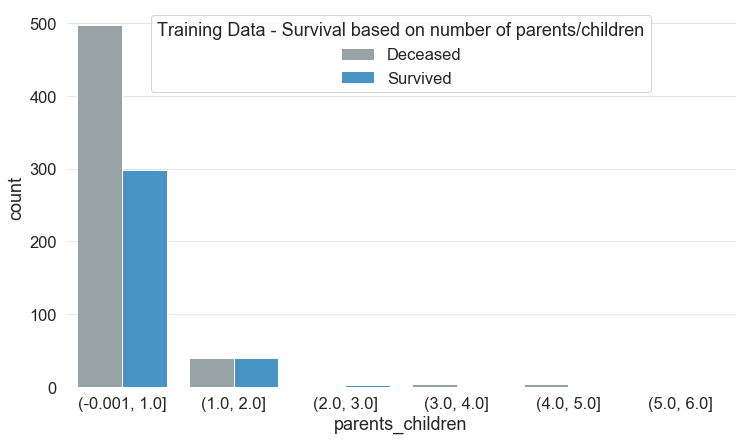

In [66]:
x = sns.countplot(x = "parents_children", hue = "survived", data = pc, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Training Data - Survival based on number of parents/children")


In [67]:
td['Family'] = td.Parch + td.SibSp
td['Is_Alone'] = td.Family == 0

### 10. Ticket



As the feature 'Ticket' does not provide any additional information, we would not consider this feature

### 11. Fare

It is clear that there is a strong correlation between the fare and the survival. **The higher a tourist paid, the higher would be his chances to survive.**

In [68]:
td.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [69]:
td['Fare_Category'] = pd.cut(td['Fare'], bins=[0,7.90,14.45,31.28,120], labels=['Low','Mid',
                                                                                      'High_Mid','High'])

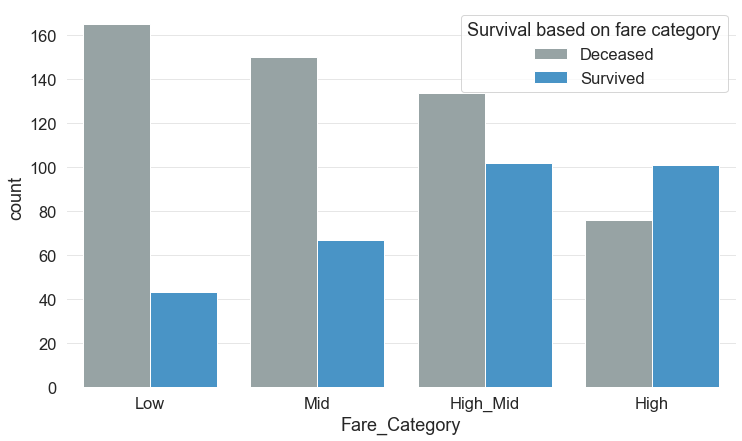

In [70]:
x = sns.countplot(x = "Fare_Category", hue = "Survived", data = td, palette=["C1", "C0"]).legend(labels = ["Deceased", "Survived"])
x.set_title("Survival based on fare category")


### 12. Cabin

As Cabin has a lot of missing values, we will impute it in following section and then use it for prediction.


### 13. Embarked

Embarked signifies where the traveler boarded from. There are three possible values for Embark - Southampton,Cherbourg,Queenstown.

In combined data, more than **70% of the people boarded from Southampton. Just under 20% boarded from Cherbourg and the rest boarded from Queenstown.**

More People who **boarded from Cherbourg survived than those who died**

Text(0.5, 1.0, 'Training Data - Survival based on embarking point.')

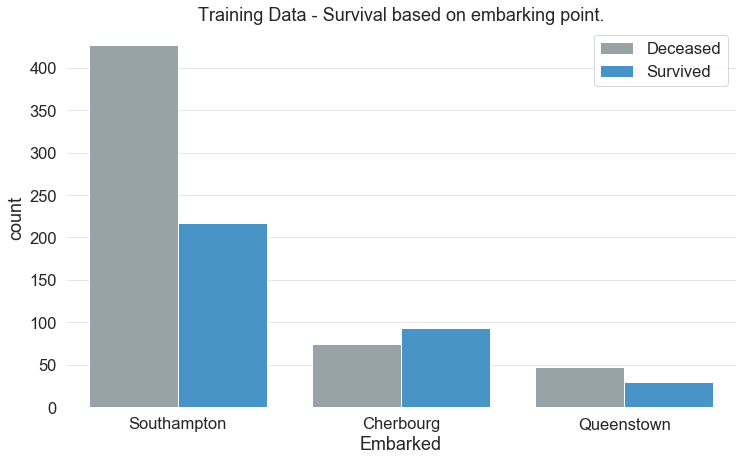

In [71]:
p = sns.countplot(x = "Embarked", hue = "Survived", data = trd, palette=["C1", "C0"])
p.set_xticklabels(["Southampton","Cherbourg","Queenstown"])
p.legend(labels = ["Deceased", "Survived"])
p.set_title("Training Data - Survival based on embarking point.")

# Data Imputation

### Embarked

Since embarked only has two missing values and the highest number of people boarded the ship from Southampton, the probablity of boarding from Southampton is high. So, we fill the missing values with Southampton. However, instead of manually putting in Southampton, we would find the mode of the Embarked column and substitute missing values with it.

In [72]:
td.Embarked.fillna(td.Embarked.mode()[0], inplace = True)

### Age

Age has **263 missing values**. To deal with missing values, we first try to categorise the people with their titles. There are **17 different titles** in the training data. We group the titles and sex and then we find the median of all the categories and replace the missing values with the median of that category.

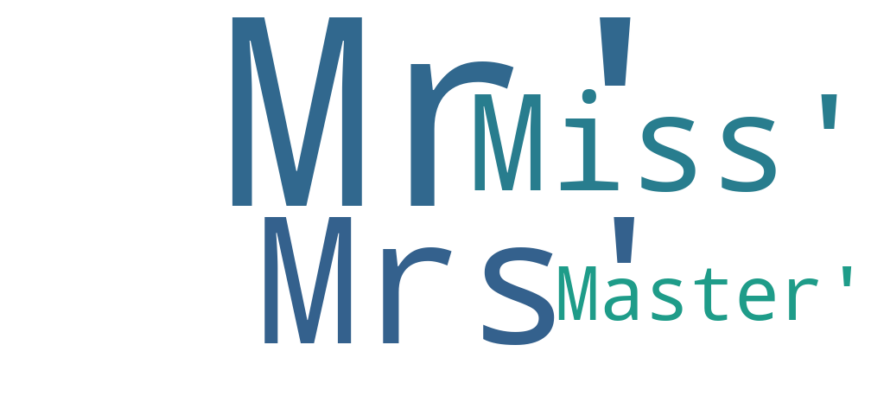

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Major             2
Mlle              2
Ms                2
Sir               1
Don               1
Jonkheer          1
Capt              1
the Countess      1
Lady              1
Mme               1
Dona              1
Name: Salutation, dtype: int64

In [73]:
td['Salutation'] = td.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip()) 
td.Salutation.nunique()
wc = WordCloud(width = 1000,height = 450,background_color = 'white').generate(str(td.Salutation.values))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

td.Salutation.value_counts()

In [74]:
grp = td.groupby(['Sex', 'Pclass'])  
td.Age = grp.Age.apply(lambda x: x.fillna(x.median()))

#If still any row remains
td.Age.fillna(td.Age.median, inplace = True)

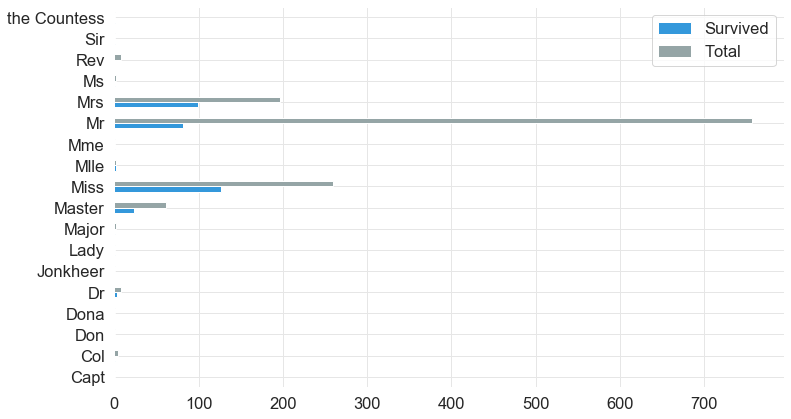

In [75]:
sal_df = pd.DataFrame({
    "Survived":
    td[td.Survived == 1].Salutation.value_counts(),
    "Total":
        td.Salutation.value_counts()
})
s = sal_df.plot.barh()

### Cabin

Assigning NA for non available cabin values. Pulling deck value from Cabin and adding a feature 'Deck'

In [76]:
td.Cabin = td.Cabin.fillna('NA')

# Encoding & dropping columns

Using Pandas' get dummies we encoded the categorical data. Later, we drop all the columns we encoded.

In [77]:
td = pd.concat([td,pd.get_dummies(td.Cabin, prefix="Cabin"),pd.get_dummies(td.Age_Range, prefix="Age_Range"), pd.get_dummies(td.Embarked, prefix="Emb", drop_first = True), pd.get_dummies(td.Salutation, prefix="Title", drop_first = True),pd.get_dummies(td.Fare_Category, prefix="Fare", drop_first = True), pd.get_dummies(td.Pclass, prefix="Class", drop_first = True)], axis=1)
td['Sex'] = LabelEncoder().fit_transform(td['Sex'])
td['Is_Alone'] = LabelEncoder().fit_transform(td['Is_Alone'])

In [78]:
td.drop(['Pclass', 'Fare','Cabin', 'Fare_Category','Name','Salutation', 'Ticket','Embarked', 'Age_Range', 'SibSp', 'Parch', 'Age'], axis=1, inplace=True)


In [79]:
td

,PassengerId,Survived,Sex,Family,Is_Alone,Cabin_A10,Cabin_A11,Cabin_A14,Cabin_A16,Cabin_A18,...,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess,Fare_Mid,Fare_High_Mid,Fare_High,Class_2,Class_3
0,1,0.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,4,1.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,5,0.0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1305,1306,NaN,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1306,1307,NaN,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1307,1308,NaN,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


# Prediction

Prediction algorithms used:

1. Gaussian Naive Bayes
2. Random Forest

NB Accuracy: 68.16%
The cross validated score for GNB is: 64.32


Text(0.5, 1.05, 'Confusion_matrix for NB')

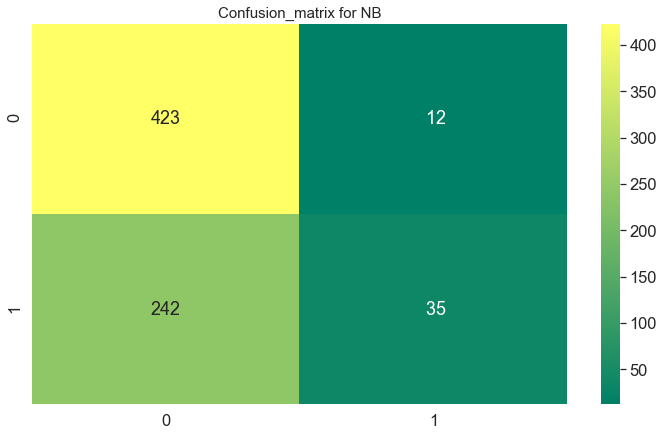

In [80]:
# Data to be predicted
X_to_be_predicted = td[td.Survived.isnull()]
X_to_be_predicted = X_to_be_predicted.drop(['Survived'], axis = 1)

#Training data
train_data = td
train_data = train_data.dropna()
feature_train = train_data['Survived']
label_train  = train_data.drop(['Survived'], axis = 1)
train_data.shape #891 x 28

##Gaussian
clf = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("NB Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")
result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for GNB is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for NB', y=1.05, size=15)

RF Accuracy: 80.45%
The cross validated score for Random forest is: 83.01


Text(0.5, 1.05, 'Confusion_matrix for RF')

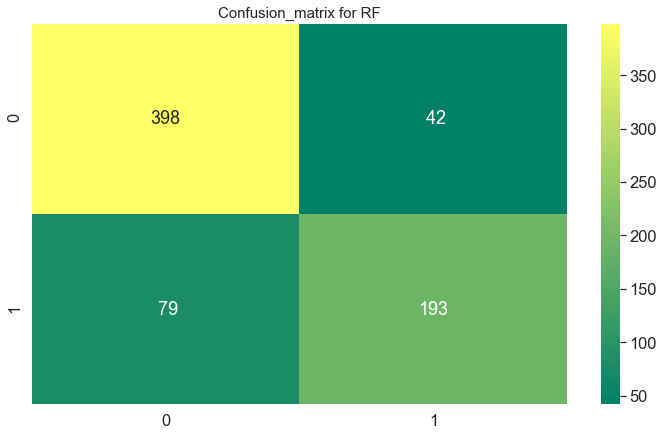

In [81]:
##Random forest
clf = RandomForestClassifier(criterion='entropy', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
x_train, x_test, y_train, y_test = train_test_split(label_train, feature_train, test_size=0.2)
clf.fit(x_train,  np.ravel(y_train))
print("RF Accuracy: "+repr(round(clf.score(x_test, y_test) * 100, 2)) + "%")

result_rf=cross_val_score(clf,x_train,y_train,cv=10,scoring='accuracy')
print('The cross validated score for Random forest is:',round(result_rf.mean()*100,2))
y_pred = cross_val_predict(clf,x_train,y_train,cv=10)
sns.heatmap(confusion_matrix(y_train,y_pred),annot=True,fmt='3.0f',cmap="summer")
plt.title('Confusion_matrix for RF', y=1.05, size=15)

In [82]:
result = clf.predict(X_to_be_predicted)
submission = pd.DataFrame({'PassengerId':X_to_be_predicted.PassengerId,'Survived':result})
submission.Survived = submission.Survived.astype(int)
print(submission.shape)
filename = 'Titanic Predictions.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

(418, 2)
Saved file: Titanic Predictions.csv


<footer id="attribution" style="float:right; color:#999; background:#fff;">
github.com/sumitmukhija
</footer>